In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib as mpl
import seaborn as sns

from scipy.stats import zscore
from umap import UMAP
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer

from drn_interactions.brain_state_decode import StateDecodeDataLoader, StateDecodePreprocessor
from drn_interactions.load import load_derived_generic, load_neurons_derived
from drn_interactions.load import load_eeg


sns.set_theme(context="poster", style="ticks")

In [386]:
from typing import Optional, Dict, Callable


def load_session(
    loader: StateDecodeDataLoader,
    preprocessor: StateDecodePreprocessor,
):
    spikes, states = loader()
    spikes, states = preprocessor(spikes, states)
    spikes.columns = spikes.columns.map(str)
    return spikes, states


def umap_spikes(
    df_piv: pd.DataFrame,
    y: Optional[pd.Series] = None,
    umap_kwargs: Optional[Dict] = None,
    y_transformer: Optional[Callable] = None,
):
    if umap_kwargs is None:
        umap_kwargs = {}
    y_vals = y
    if y_transformer is not None:
        y_vals = y_transformer(y)
    mod = UMAP(**umap_kwargs)
    mod = mod.fit(df_piv.values, y=y_vals)
    df_fit = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=df_piv.index)
    if y is not None:
        df_fit = df_fit.join(y)
    df_fit = df_fit.reset_index()
    return df_fit


def plot_umap(
    df_fit: pd.DataFrame, y: Optional[str] = None, ax: Optional[plt.Axes] = None, 
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    sns.scatterplot(x="d1", y="d2", hue=y, data=df_fit, ax=ax, edgecolor="black", alpha=0.2)
    ax.locator_params(nbins=3)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.legend().remove()
    sns.despine(ax=ax)
    return ax


def plot_similarity_map(spikes, ax=None, z=False, **heatmap_kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    X = spikes.values if not z else spikes.apply(zscore)
    sim = 1 - pairwise_distances(X, metric="cosine")

    sns.heatmap(sim,  ax=ax, **heatmap_kwargs)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine(left=True, bottom=True, ax=ax, )
    return ax

def plot_spectra(df: pd.DataFrame, ax=None, **heatmap_kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 2))
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    df2 = df.apply(zscore).transpose().apply(zscore).transpose()
    values = gaussian_filter(df2, sigma=(1.5, 1.5))
    dfp = pd.DataFrame(values, index=df2.index, columns=df2.columns)
    dfp = dfp.transpose().iloc[::-1]
    df = df.apply(gaussian_filter, sigma=1)
    sns.heatmap(dfp, ax=ax, **heatmap_kwargs)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine(left=True, bottom=True, ax=ax)
    return ax

def plot_state(states, state_1="act", ax=None, index_trnsformer=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))
    vals =  np.where(states == state_1, 1, 0)
    x = states.index if index_trnsformer is None else index_trnsformer(states.index) 
    ax.plot(x, vals, color="black")
    ax.set_yticks([0, 1])
    state_2 = "sw" if state_1 == "act" else "act"
    ax.set_yticklabels([state_2, state_1])
    ax.margins(x=0)
    sns.despine(ax=ax, left=True)
    return ax

def plot_spikes(spikes, tfidf=False, minmax=False, ax=None, **heatmap_kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))
    if heatmap_kwargs is None:
        heatmap_kwargs = {}

    
    if tfidf:
        X = TfidfTransformer().fit_transform(spikes.values).toarray().T
    elif minmax:
        X = MinMaxScaler().fit_transform(spikes.values).T
    else:
        X = spikes.values.T
    sns.heatmap(X, ax=ax, **heatmap_kwargs)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine(left=True, bottom=True, ax=ax)
    
    return ax


In [131]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons.merge(eeg_states[["session_name"]].drop_duplicates(), on="session_name")["session_name"].unique()

df_fft = load_eeg("pre").query(
    "frequency < 8 and frequency > 0 and timepoint_s < 1800"
)

In [431]:
session = sessions[3] 

loader =StateDecodeDataLoader(
    session_name=session,
    block="pre",
    t_start=0,
    t_stop=1800,
    bin_width=1,
    )
preprocessor = StateDecodePreprocessor(thresh_empty=2)

spikes, states = load_session(loader, preprocessor)
df_fit = umap_spikes(spikes, y=states, y_transformer=lambda x: np.where(x == "sw", 1, 0))

df1 = (
    df_fft.query("session_name == @session")
    .pivot(index="timepoint_s", columns="frequency", values="fft_value")
)

C:\Users\roryl\AppData\Local\Temp\ipykernel_16772\3211118457.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_spec.set_yticklabels([8, 4.25, 0.5])
C:\Users\roryl\AppData\Local\Temp\ipykernel_16772\3211118457.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_spec.set_ticklabels(cbar_spec.get_ticks(), fontsize="x-small")
C:\Users\roryl\AppData\Local\Temp\ipykernel_16772\3211118457.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_sim.set_ticklabels(cbar_sim.get_ticks(), fontsize="x-small")
C:\Users\roryl\AppData\Local\Temp\ipykernel_16772\3211118457.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_spikes.set_yticklabels(["Unit 1", f"Unit {int(spikes.shape[1])}"], rotation=0, fontsize="x-small")
C:\Users\roryl\AppData\Local\Temp\ipykernel_16772\3211118457.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
 

<AxesSubplot:xlabel='UMAP-1', ylabel='UMAP-2'>

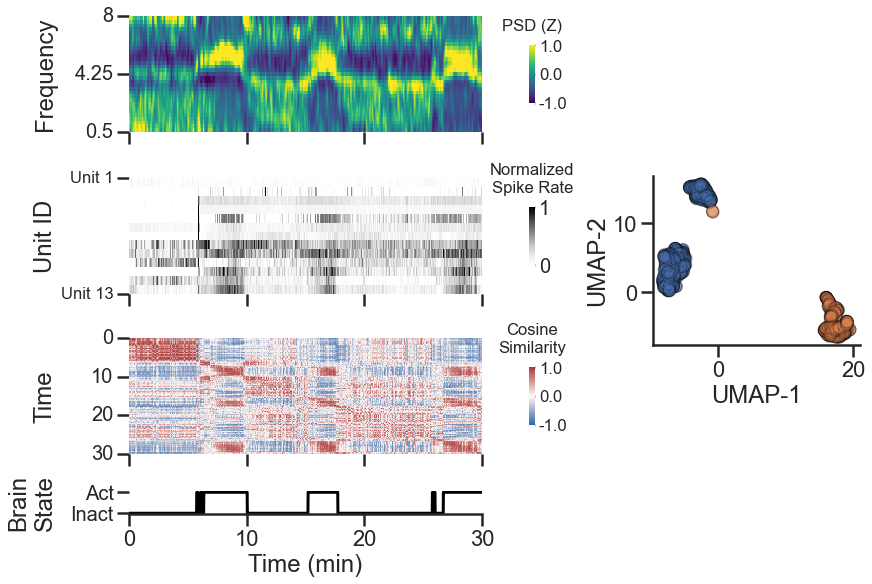

In [432]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)

subfigs = fig.subfigures(
    1, 2, width_ratios=[1, 0.5],    
    )

spec_heatmap_kwargs = dict(center=0, cmap="viridis", cbar_kws=dict(shrink=0.5, aspect=10, pad=0.1), vmin=-1, vmax=1)
sim_heatmap_kwargs = dict(center=0, cmap="vlag", cbar_kws=dict(shrink=0.5, aspect=10, pad=0.1), vmin=-1, vmax=1)
spikes_heatmap_kwargs = dict(cmap="Greys", 
cbar_kws=dict(shrink=0.5, aspect=10, pad=0.1),
    vmin=0, vmax=1
 )


f = subfigs[0]
gs = f.add_gridspec(4, 1, height_ratios=[0.5, 0.5, 0.5, 0.1,], hspace=0.15)

ax_spec = f.add_subplot(gs[0, 0])
ax_sim = f.add_subplot(gs[2, 0])
ax_spikes = f.add_subplot(gs[1, 0])
ax_states = f.add_subplot(gs[3, 0])

plot_spectra(df1, ax=ax_spec, **spec_heatmap_kwargs)
ax_spec.set_ylabel("Frequency")

ax_spec.yaxis.set_major_locator(plt.LinearLocator(numticks=3))
ax_spec.set_yticklabels([8, 4.25, 0.5])
ax_spec.xaxis.set_major_locator(plt.LinearLocator(numticks=4))
cbar_spec = ax_spec.collections[0].colorbar
cbar_spec.set_ticks(plt.LinearLocator(numticks=3))
cbar_spec.set_ticklabels(cbar_spec.get_ticks(), fontsize="x-small")
cbar_spec.ax.set_title(label="PSD (Z)", fontsize="x-small", pad=15)
cbar_spec.ax.tick_params(length =0.3)


plot_similarity_map(spikes, ax=ax_sim, z=True, **sim_heatmap_kwargs)
ax_sim.set_ylabel("Time")
ax_sim.set_xticks([0, 600, 1200, 1800])
ax_sim.set_yticks([0, 600, 1200, 1800])
ax_sim.set_yticklabels([0, 10, 20, 30])
cbar_sim = ax_sim.collections[0].colorbar
cbar_sim.set_ticks(plt.LinearLocator(numticks=3))
cbar_sim.set_ticklabels(cbar_sim.get_ticks(), fontsize="x-small")
cbar_sim.ax.set_title(label="Cosine\nSimilarity", fontsize="x-small", pad=15)
cbar_sim.ax.tick_params(length =0.3)

plot_spikes(spikes, ax=ax_spikes, tfidf=False, minmax=True, **spikes_heatmap_kwargs)
ax_spikes.yaxis.set_major_locator(plt.LinearLocator(numticks=2))

ax_spikes.set_ylabel("Unit ID")
ax_spikes.set_xticks([0, 600, 1200, 1800])
ax_spikes.set_yticklabels(["Unit 1", f"Unit {int(spikes.shape[1])}"], rotation=0, fontsize="x-small")

cbar_spikes = ax_spikes.collections[0].colorbar
cbar_spikes.set_ticks(plt.LinearLocator(numticks=2))
cbar_spikes.set_ticklabels([0, 1], fontsize="small")
cbar_spikes.ax.set_title(label="Normalized\nSpike Rate", fontsize="x-small", pad=15)
cbar_spikes.ax.tick_params(length =0.3)




plot_state(states, ax=ax_states, index_trnsformer=lambda x: x / 60)
ax_states.xaxis.set_major_locator(plt.MultipleLocator(10))
ax_states.set_xticks([0, 10, 20, 30])
ax_states.set_ylabel("Brain\nState")
ax_states.set_yticklabels(["Inact", "Act",])
ax_states.set_xlabel("Time (min)")

f.align_ylabels()


for ax in (ax_spec, ax_sim, ax_states):
    ax.set_yticklabels(ax.get_yticklabels(), fontsize="small")

f_umap = subfigs[1]
gs = f_umap.add_gridspec(3, 1)
ax_umap = f_umap.add_subplot(gs[1, 0])
plot_umap(df_fit, y="state", ax=ax_umap)